In [201]:
import requests
import json
import pandas as pd
import glob
import os
from scipy.stats import linregress
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
from config import covid_api
from config import google_api
import gmaps
import numpy


# NOTES:
# https://api.covid19api.com/world/total
# This is all data - returns 10MB+
# https://api.covid19api.com/all


ModuleNotFoundError: No module named 'config'

In [2]:
# From COVID-19 API
# https://covid19api.com/

#base_url = 'https://api.covid19api.com/summary'
#headers = {"X-Access-Token":covid_api}

#response = requests.get(base_url, headers=headers).json()
#print(json.dumps(response, indent=4, sort_keys=True))
#response['Countries']

In [185]:
# -----------------------
# Get risk factor data for North Carolina, based on census data
# THIS IS WORKING PROPERLY
# -----------------------

# Import CRE csv from
# https://www2.census.gov/data/experimental-data-products/community-resilience-estimates/2020/

#risk_path = "https://www2.census.gov/data/experimental-data-products/community-resilience-estimates/2020/cre-2018-a11.csv"
# If the above breaks, use the downloaded CSV
risk_path = "data/cre-2018-a11.csv"
risk_df = pd.read_csv(risk_path)

# Break down by North Carolina
nc_risk_df = risk_df.loc[risk_df['STABREV']=='NC']

# Display dataframe
nc_risk_df

FileNotFoundError: [Errno 2] File data/cre-2018-a11.csv does not exist: 'data/cre-2018-a11.csv'

In [186]:
# -----------------------
# Clean up the data
# THIS IS WORKING PROPERLY
# -----------------------
nc_risk_df = nc_risk_df[['tract','rfgrp','prednum','ctname','popuni']]
nc_risk_rename_df = nc_risk_df.rename(columns={
    'rfgrp':'risk_group',
    'prednum':'risk_pop',
    'ctname':'county',
    'popuni':'total_pop'})

nc_risk_rename_df['county'].replace(' County, NC','',regex=True,inplace=True)

# Now we only need to keep the data where tract = 0, as that's the county summary
nc_risk_grouped = nc_risk_rename_df.groupby(['county','tract','risk_group']).sum()
nc_risk_grouped.reset_index(inplace=True)
nc_risk_filtered = nc_risk_grouped[nc_risk_grouped['tract'] == 0] 

# Display the dataframe
nc_risk_filtered = nc_risk_filtered[['county','risk_group','risk_pop','total_pop']]
nc_risk_filtered

,county,risk_group,risk_pop,total_pop
0,Alamance,0RF,48284,161790
1,Alamance,1-2RF,74707,161790
2,Alamance,3PLRF,38799,161790
111,Alexander,0RF,9789,36096
112,Alexander,1-2RF,17442,36096
...,...,...,...,...
6844,Yadkin,1-2RF,16689,37498
6845,Yadkin,3PLRF,10706,37498
6867,Yancey,0RF,4307,17870
6868,Yancey,1-2RF,8271,17870


In [187]:
# -----------------------
# Reports statewide North Carolina risk factor groups
# THIS IS WORKING PROPERLY
# -----------------------

# Make a new dataframe from the other
nc_overall_risk_df = nc_risk_filtered

# Group by risk factors
nc_overall_risk = nc_overall_risk_df.groupby('risk_group').sum()

# Build new series to hold percentages
nc_overall_risk['percentage'] = ''

# Iterate over rows to calculate percentages, round, and store in the new series 
for index, row in nc_overall_risk.iterrows():
    nc_overall_risk.at[index,'percentage'] = round((row['risk_pop'] / row['total_pop'])*100,2)

# Display the dataframe
nc_overall_risk

,risk_pop,total_pop,percentage
risk_group,,,
0RF,2896542,10219101,28.34
1-2RF,4866961,10219101,47.63
3PLRF,2455598,10219101,24.03


In [189]:
# -----------------------
# Reports fisk factor groups, by county, for North Carolina, based on census data
# THIS IS WORKING PROPERLY
# -----------------------

nc_county_risk = nc_risk_filtered

# Build new series to hold percentages
nc_county_risk['percentage'] = ''

# Iterate over rows to calculate percentages, round, and store in the new series 
for index, row in nc_county_risk.iterrows():
    nc_county_risk.at[index,'percentage'] = round((row['risk_pop'] / row['total_pop'])*100,2)

# Display the dataframe
nc_county_risk


,county,risk_group,risk_pop,total_pop,percentage
0,Alamance,0RF,48284,161790,29.84
1,Alamance,1-2RF,74707,161790,46.18
2,Alamance,3PLRF,38799,161790,23.98
111,Alexander,0RF,9789,36096,27.12
112,Alexander,1-2RF,17442,36096,48.32
...,...,...,...,...,...
6844,Yadkin,1-2RF,16689,37498,44.51
6845,Yadkin,3PLRF,10706,37498,28.55
6867,Yancey,0RF,4307,17870,24.1
6868,Yancey,1-2RF,8271,17870,46.28


In [190]:
# -----------------------
# This is a NYTimes report on national COVID-19 cases and deaths, sorted by county
# From: https://github.com/nytimes/covid-19-data (us-counties.csv)
# THIS IS WORKING PROPERLY
# -----------------------

# Pull in the live data
counties_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
# If the above breaks, we can refer to the saved version of the csv, below:
#counties_path = "data/us-counties.csv"

# Save to a dataframe
covid_df = pd.read_csv(counties_path)

# Sort for NC
covid_county_df = covid_df.loc[covid_df['state']=='North Carolina']

# Drop irrelevant column(s)
covid_county_clean_df = covid_county_df.drop(['fips'], 1)

# Grab last 100 rows (for 100 counties to get latest data)
covid_county_latest_df = covid_county_clean_df.tail(100)

# Diplay the dataframe
covid_county_latest_df

,date,county,state,cases,deaths
349033,2020-07-19,Alamance,North Carolina,1684,39
349034,2020-07-19,Alexander,North Carolina,213,1
349035,2020-07-19,Alleghany,North Carolina,53,0
349036,2020-07-19,Anson,North Carolina,260,1
349037,2020-07-19,Ashe,North Carolina,73,1
...,...,...,...,...,...
349128,2020-07-19,Wayne,North Carolina,2100,34
349129,2020-07-19,Wilkes,North Carolina,657,7
349130,2020-07-19,Wilson,North Carolina,1128,28
349131,2020-07-19,Yadkin,North Carolina,404,6


In [191]:
# -----------------------
# Build a dataframe that shows worst 10 counties in cases and deaths
# THIS IS WORKING PROPERLY
# -----------------------

# Sort by cases, highest to lowest
sorted_cases = covid_county_latest_df.sort_values(by=['cases'],ascending=False).reset_index()
# Sort by deaths, highest to lowest
sorted_deaths = covid_county_latest_df.sort_values(by=['deaths'],ascending=False).reset_index()

# Build a new dataframe to hold top counties and the value, sorted by cases and deaths
top_df = pd.DataFrame(columns=['Most cases','Case count','Most deaths','Death count'])

# Add the cases to the new dataframe
top_df['Most cases'] = sorted_cases['county'].values
top_df['Case count'] = sorted_cases['cases'].values

# Add the deaths to the new dataframe
top_df['Most deaths'] = sorted_deaths['county'].values
top_df['Death count'] = sorted_deaths['deaths'].values

# Show the top 10 counties for cases and deaths
top_df.head(10)

,Most cases,Case count,Most deaths,Death count
0,Mecklenburg,17379,Mecklenburg,179
1,Wake,8800,Guilford,133
2,Durham,5072,Wake,89
3,Forsyth,4196,Durham,73
4,Guilford,4127,Henderson,52
5,Johnston,2386,Buncombe,50
6,Gaston,2267,Chatham,47
7,Union,2190,Robeson,46
8,Wayne,2100,Cumberland,46
9,Cabarrus,1949,Rowan,45


In [192]:
# -----------------------
# Combine dataframes from NYTimes data and CRE data
# NYT = covid_county_latest_df
# CRE = nc_county_risk
# THIS IS WORKING PROPERLY
# -----------------------

# Do the merge
combined_data = pd.merge(nc_county_risk, covid_county_latest_df, on='county', how='outer')

# Display the dataframe
combined_data


,county,risk_group,risk_pop,total_pop,percentage,date,state,cases,deaths
0,Alamance,0RF,48284,161790,29.84,2020-07-19,North Carolina,1684,39
1,Alamance,1-2RF,74707,161790,46.18,2020-07-19,North Carolina,1684,39
2,Alamance,3PLRF,38799,161790,23.98,2020-07-19,North Carolina,1684,39
3,Alexander,0RF,9789,36096,27.12,2020-07-19,North Carolina,213,1
4,Alexander,1-2RF,17442,36096,48.32,2020-07-19,North Carolina,213,1
...,...,...,...,...,...,...,...,...,...
295,Yadkin,1-2RF,16689,37498,44.51,2020-07-19,North Carolina,404,6
296,Yadkin,3PLRF,10706,37498,28.55,2020-07-19,North Carolina,404,6
297,Yancey,0RF,4307,17870,24.1,2020-07-19,North Carolina,67,0
298,Yancey,1-2RF,8271,17870,46.28,2020-07-19,North Carolina,67,0


In [193]:
# -----------------------
# Build dataframe to show:
#     Cases and deaths as a percentage of the county population
#     Deaths as a percentage of cases
# THIS IS WORKING PROPERLY
# -----------------------

# Build empty dataframe and order columns
summary_df = pd.DataFrame(columns={
    'county',
    'cases_pop_pct',
    'deaths_cases_pct',
    'deaths_pop_pct',
    'cases',
    'deaths',
    'population'})
summary_df = summary_df[[
    'county','cases','deaths','population','cases_pop_pct','deaths_pop_pct','deaths_cases_pct']]


# Set empty lists to store values
county_lst = []
cases_lst = []
deaths_lst = []
pop_lst = []

# This variable checks to see if we've seen this county already
county = ''

#Iterate through the data and build lists to go into the new summary dataframe
for i, row in combined_data.iterrows():
    if county == row[0]: # This handles 2nd and 3rd occurrance of county
        pass
    else: # This handles first occurrance of county
        county_lst.append(row[0])
        cases_lst.append(row[7])
        deaths_lst.append(row[8])
        pop_lst.append(row[3])
        
        county = row[0]

# Build the summary dataframe
summary_df['county'] = county_lst
summary_df['cases'] = cases_lst
summary_df['deaths'] = deaths_lst
summary_df['population'] = pop_lst

# Do calculations for percentages
for i, row in summary_df.iterrows():
    summary_df.loc[i,'cases_pop_pct']= f'{round(((row[1]/row[3])*100),4)}%'
    summary_df.loc[i,'deaths_pop_pct']= f'{round(((row[2]/row[3])*100),4)}%'
    summary_df.loc[i,'deaths_cases_pct']= f'{round(((row[2]/row[1])*100),4)}%'

# Display the summary dataframe   
summary_df

,county,cases,deaths,population,cases_pop_pct,deaths_pop_pct,deaths_cases_pct
0,Alamance,1684,39,161790,1.0409%,0.0241%,2.3159%
1,Alexander,213,1,36096,0.5901%,0.0028%,0.4695%
2,Alleghany,53,0,11146,0.4755%,0.0%,0.0%
3,Anson,260,1,22949,1.1329%,0.0044%,0.3846%
4,Ashe,73,1,27068,0.2697%,0.0037%,1.3699%
...,...,...,...,...,...,...,...
95,Wayne,2100,34,122647,1.7122%,0.0277%,1.619%
96,Wilkes,657,7,68118,0.9645%,0.0103%,1.0654%
97,Wilson,1128,28,80922,1.3939%,0.0346%,2.4823%
98,Yadkin,404,6,37498,1.0774%,0.016%,1.4851%


In [194]:
# -----------------------
# COVID testing location data
# From https://github.com/codersagainstcovidorg/covid19testing-backend
# -----------------------

testing_df = pd.DataFrame(columns=['Name','Lat','Lon','City','State','Collecting','Evaluating'])
testing_df

base_url = "http://api.findcovidtesting.com/api/v1/location"
response = requests.get(base_url).json()

In [11]:
# -----------------------
# Use this to see how the response is structured:
#response[0]

# -----------------------
# Relevant info seems to be:
#     location_name
#     is_collecting_samples - boolean
#     is_evaluating_symptoms - boolean
#     location_address_locality = city
#     location_address_region = state
#     location_latitude
#     location_longitude


In [12]:
# Iterate through the response and store selected variables in dataframe

for i in range(len(response)):
    if response[i]['location_address_region'] == 'NC':
        testing_df.loc[i,'Name'] = response[i]['location_name']
        testing_df.loc[i,'Lat'] = response[i]['location_latitude']
        testing_df.loc[i,'Lon'] = response[i]['location_longitude']
        testing_df.loc[i,'City'] = response[i]['location_address_locality']
        testing_df.loc[i,'State'] = response[i]['location_address_region']
        testing_df.loc[i,'Collecting'] = response[i]['is_collecting_samples']
        testing_df.loc[i,'Evaluating'] = response[i]['is_evaluating_symptoms']

# Display the dataframe       
testing_df

,Name,Lat,Lon,City,State,Collecting,Evaluating
9,Farmville Community Center,35.5933,-77.5896,Farmville,NC,True,False
15,Southside Recreation Center (Guilford County D...,35.9485,-80.0088,High Point,NC,True,True
19,Halifax County Health Department,36.3297,-77.59,Halifax,NC,True,True
37,MEDAC Urgent Care - Military Cutoff,34.2249,-77.8305,Wilmington,NC,True,True
51,FastMed Urgent Care,35.0086,-80.5616,Monroe,NC,True,True
...,...,...,...,...,...,...,...
9549,Ft. Bragg/Womack Army Medical Center,35.1467,-79.0021,Fayetteville,NC,True,True
9672,Hyde County Health Department,35.4204,-76.3192,Swan Quarter,NC,True,False
9772,BF Grady Elementary School,35.0561,-77.8303,Alberston,NC,True,False
9783,Snowbird Health Clinic,35.3037,-83.8738,Robbinsville,NC,True,True


In [13]:
gmaps.configure(api_key=google_api)

# Build the map
# Set center and zoom level
fig = gmaps.figure(map_type='HYBRID',center=(35.3,-79.5), zoom_level=7)
locations = testing_df[['Lat', 'Lon']]
hover = testing_df['Name'].tolist()

symbols = gmaps.symbol_layer(locations, fill_color='white', stroke_color='white', scale = 2, info_box_content = hover)
fig.add_layer(symbols)


# Display the map
fig

NameError: name 'gmaps' is not defined

In [358]:
# Upload and Combine NC County Demographic CSV's from https://www.census.gov/quickfacts/fact/table/US/PST045219

# Find all csv files using glob pattern matching with extension = 'csv' by saving results in a list titled all_county
os.chdir('/Users/Data/GitHub/project_1/nc_county_demographics')
extension = 'csv'
all_county = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
nc_demographic = pd.concat([pd.read_csv(f) for f in all_county ])
nc_demographic = nc_demographic.dropna().rename(columns={'Fact': 'county'})

# Create New Dataframe to retrieve the demographic data per county
# Set Columns for new Dataframe
demo_summary = pd.DataFrame(columns=['County','% Female','% White','% Black','% Hispanic','% Population Under 18'
                                     '% Graduated Highschool','% College Graduate','People Per Household',
                                     'Median Household Income','Poverty Rate','% Without Health Insurance (<65)'])

# Set Values for New Demographic DataFrame
demo_summary['County'] = nc_demographic['county'].values
demo_summary['Female (%)'] = nc_demographic['Female persons, percent'].values
demo_summary['White (%)'] = nc_demographic['White alone, not Hispanic or Latino, percent'].values
demo_summary['Black (%)'] = nc_demographic['Black or African American alone, percent'].values
demo_summary['Hispanic (%)'] = nc_demographic['Hispanic or Latino, percent'].values
demo_summary['Population Under 18 (%)'] = nc_demographic['Persons under 18 years, percent'].values
demo_summary['Population 65 and Over (%)'] = nc_demographic['Persons 65 years and over, percent'].values
demo_summary['Graduated Highschool (%)'] = nc_demographic['High school graduate or higher, percent of persons age 25 years+, 2014-2018'].values
demo_summary['College Graduate (%)'] = nc_demographic['Bachelors degree or higher, percent of persons age 25 years+, 2014-2018'].values
demo_summary['Median Household Income'] = nc_demographic['Median household income (in 2018 dollars), 2014-2018'].values
demo_summary['Poverty Rate'] = nc_demographic['Persons in poverty, percent'].values
demo_summary['% Without Health Insurance (<65)'] = nc_demographic['Persons  without health insurance, under age 65 years, percent'].values

# Format New Demographic Data
demo_summary1 = demo_summary.transpose().dropna()
demo_summary2 = demo_summary1.transpose()
demo_summary2.sort_values('County', axis = 0, ascending = True, inplace = True)
demo_summary3 = demo_summary2.reset_index(drop = True)

# Add data from summary_df
demo_summary3['Population'] = summary_df['population'].values
demo_summary3['Cases'] = summary_df['cases'].values
demo_summary3['Deaths'] = summary_df['deaths'].values
demo_summary3['Cases/Population (%)'] = summary_df['cases_pop_pct'].values
demo_summary3['Cases Per 10,000 Residents'] = ((summary_df['cases'] / summary_df['population']) * 10000).values
demo_summary3['Deaths/Population (%)'] = summary_df['deaths_pop_pct'].values
demo_summary3['Deaths/Cases (%)'] = summary_df['deaths_cases_pct'].values


# Reorder Columns to look nice
demo_summary4 = demo_summary3[['County','Population','Female (%)','White (%)','Black (%)',
                               'Hispanic (%)','Population Under 18 (%)','Population 65 and Over (%)',
                               'Graduated Highschool (%)','College Graduate (%)','Median Household Income',
                               'Poverty Rate','% Without Health Insurance (<65)','Cases','Cases Per 10,000 Residents',
                               'Deaths','Cases/Population (%)','Deaths/Population (%)','Deaths/Cases (%)']]
demo_summary4.head(50)

,County,Population,Female (%),White (%),Black (%),Hispanic (%),Population Under 18 (%),Population 65 and Over (%),Graduated Highschool (%),College Graduate (%),Median Household Income,Poverty Rate,% Without Health Insurance (<65),Cases,"Cases Per 10,000 Residents",Deaths,Cases/Population (%),Deaths/Population (%),Deaths/Cases (%)
0,Alamance,161790,52.50%,62.90%,20.90%,13.10%,22.00%,17.10%,85.50%,24.00%,"$45,735",13.50%,13.80%,1684,104.085543,39,1.0409%,0.0241%,2.3159%
1,Alexander,36096,49.00%,86.70%,5.90%,4.80%,19.90%,20.40%,81.60%,14.70%,"$44,961",13.00%,12.80%,213,59.009309,1,0.5901%,0.0028%,0.4695%
2,Alleghany,11146,50.40%,86.70%,1.80%,9.90%,17.00%,28.00%,76.60%,16.70%,"$37,558",18.70%,17.80%,53,47.550691,0,0.4755%,0.0%,0.0%
3,Anson,22949,48.70%,44.30%,48.50%,4.10%,19.80%,19.30%,80.50%,9.60%,"$39,126",20.50%,13.40%,260,113.294697,1,1.1329%,0.0044%,0.3846%
4,Ashe,27068,51.00%,92.30%,1.00%,5.10%,17.40%,26.60%,84.20%,19.00%,"$40,978",16.90%,15.40%,73,26.969115,1,0.2697%,0.0037%,1.3699%
5,Avery,15235,45.80%,88.50%,4.70%,5.10%,14.70%,22.90%,82.30%,20.60%,"$38,134",16.80%,18.10%,42,27.568100,0,0.2757%,0.0%,0.0%
6,Beaufort,46988,52.50%,65.90%,24.80%,8.00%,19.80%,24.60%,87.60%,19.40%,"$43,688",18.10%,13.10%,197,41.925598,0,0.4193%,0.0%,0.0%
7,Bertie,17932,49.30%,34.70%,61.10%,2.40%,17.40%,23.60%,78.70%,13.40%,"$33,143",23.50%,12.60%,178,99.263886,4,0.9926%,0.0223%,2.2472%
8,Bladen,33129,52.50%,54.90%,34.00%,7.80%,20.30%,22.80%,80.10%,15.10%,"$32,378",29.10%,17.80%,485,146.397416,5,1.464%,0.0151%,1.0309%
9,Brunswick,136484,52.30%,82.30%,10.00%,4.90%,14.70%,32.60%,90.40%,28.60%,"$54,406",10.50%,13.70%,943,69.092348,13,0.6909%,0.0095%,1.3786%


In [383]:
# Format Dataframe so column values work with regression equations
df = demo_summary4.astype(str)
df.dtypes

for x in df:
    if x == "County":
        continue
    if(df[x].dtype == 'object'):
        if df[x].str.contains('%').any():
            df[x] = df[x].str.replace(',', '')
            df[x] = df[x].str.replace('%', '')
            df[x] = df[x].astype('float')
            continue
        df[x] = df[x].str.replace('$', '')
        df[x] = df[x].str.replace('.', '')
        df[x] = df[x].str.replace(',', '')
        df[x] = df[x].astype('float')
        
# Reset Cases Per 10,000 Residents Value
df['Cases Per 10,000 Residents'] = ((summary_df['cases'] / summary_df['population']) * 10000).values
df

,County,Population,Female (%),White (%),Black (%),Hispanic (%),Population Under 18 (%),Population 65 and Over (%),Graduated Highschool (%),College Graduate (%),Median Household Income,Poverty Rate,% Without Health Insurance (<65),Cases,"Cases Per 10,000 Residents",Deaths,Cases/Population (%),Deaths/Population (%),Deaths/Cases (%)
0,Alamance,161790.0,52.5,62.9,20.9,13.1,22.0,17.1,85.5,24.0,45735.0,13.5,13.8,1684.0,104.085543,39.0,1.0409,0.0241,2.3159
1,Alexander,36096.0,49.0,86.7,5.9,4.8,19.9,20.4,81.6,14.7,44961.0,13.0,12.8,213.0,59.009309,1.0,0.5901,0.0028,0.4695
2,Alleghany,11146.0,50.4,86.7,1.8,9.9,17.0,28.0,76.6,16.7,37558.0,18.7,17.8,53.0,47.550691,0.0,0.4755,0.0000,0.0000
3,Anson,22949.0,48.7,44.3,48.5,4.1,19.8,19.3,80.5,9.6,39126.0,20.5,13.4,260.0,113.294697,1.0,1.1329,0.0044,0.3846
4,Ashe,27068.0,51.0,92.3,1.0,5.1,17.4,26.6,84.2,19.0,40978.0,16.9,15.4,73.0,26.969115,1.0,0.2697,0.0037,1.3699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Wayne,122647.0,51.3,52.7,32.4,12.4,23.6,16.9,84.1,19.5,42192.0,20.2,14.8,2100.0,171.223104,34.0,1.7122,0.0277,1.6190
96,Wilkes,68118.0,50.9,86.7,4.7,6.9,20.1,22.2,78.6,15.5,40829.0,18.9,15.3,657.0,96.450277,7.0,0.9645,0.0103,1.0654
97,Wilson,80922.0,52.6,46.8,40.5,10.8,22.7,18.7,80.3,19.6,42850.0,21.1,14.7,1128.0,139.393490,28.0,1.3939,0.0346,2.4823
98,Yadkin,37498.0,50.5,83.8,3.4,11.5,20.8,20.5,81.0,11.3,42876.0,13.0,14.5,404.0,107.739079,6.0,1.0774,0.0160,1.4851


The r-squared is: 0.025388019699167846


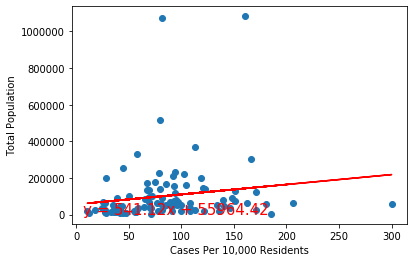

In [384]:
# Print out the r-squared value along with the plot.
x_values = df['Cases Per 10,000 Residents']
y_values = df['Population']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Total Population')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.153120069269133


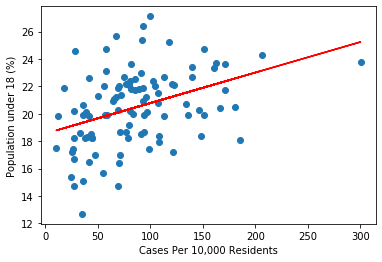

In [385]:
x_values = demo_summary4['Cases Per 10,000 Residents']
y_values = df['Population Under 18 (%)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Population under 18 (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.09708798310315614


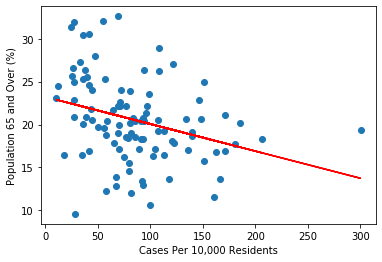

In [386]:
x_values = df['Cases Per 10,000 Residents']
y_values = df['Population 65 and Over (%)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Population 65 and Over (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.00011921799343584171


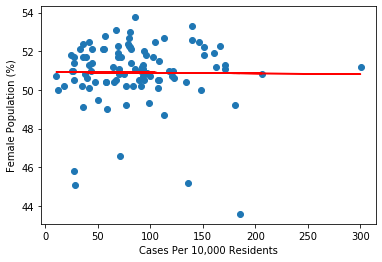

In [387]:
x_values = df['Cases Per 10,000 Residents']
y_values = df['Female (%)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Female Population (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.244964531671584


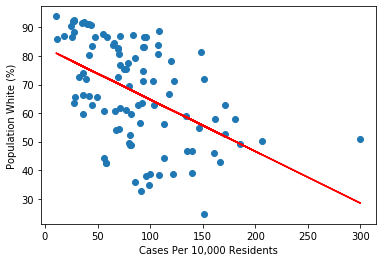

In [388]:
x_values = df['Cases Per 10,000 Residents']
y_values = df['White (%)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Population White (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.005906828564561302


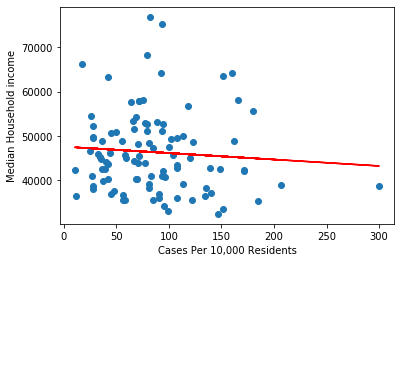

In [375]:
x_values = df['Cases Per 10,000 Residents']
y_values = df['Median Household Income']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Median Household income')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.06353242077776453


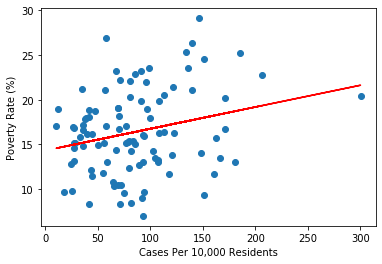

In [390]:
x_values = df['Cases Per 10,000 Residents']
y_values = df['Poverty Rate']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Poverty Rate (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.1618532039617299


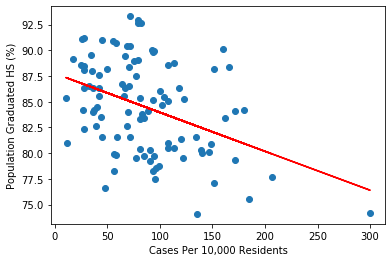

In [391]:
x_values = df['Cases Per 10,000 Residents']
y_values = df['Graduated Highschool (%)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Population Graduated HS (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.011240722533396214


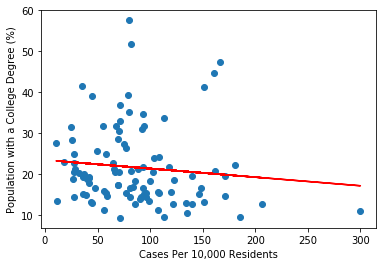

In [393]:
x_values = df['Cases Per 10,000 Residents']
y_values = df["College Graduate (%)"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel("Population with a College Degree (%)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [395]:
x = df[['Population','Population 65 and Over (%)', 'White (%)', 'Poverty Rate','College Graduate (%)']]

#regr = linear_model.LinearRegression()
#regr.fit(X, df["Cases Per 10000 Residents"])

X = sm.add_constant(x) # adding a constant

model = sm.OLS(df["Cases Per 10,000 Residents"], X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                                OLS Regression Results                                
Dep. Variable:     Cases Per 10,000 Residents   R-squared:                       0.267
Model:                                    OLS   Adj. R-squared:                  0.228
Method:                         Least Squares   F-statistic:                     6.855
Date:                        Tue, 21 Jul 2020   Prob (F-statistic):           1.71e-05
Time:                                10:15:53   Log-Likelihood:                -514.23
No. Observations:                         100   AIC:                             1040.
Df Residuals:                              94   BIC:                             1056.
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------